In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install --upgrade spacy
!python -m spacy download en_core_web_md
!python -m spacy download xx_sent_ud_sm
!pip install --upgrade spacy_langdetect

In [ ]:
!pip install --upgrade gensim==3.8.3

In [ ]:
# Install of a visualizer for LDA
!pip install pyLDAvis==2.1.2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.symbols import ORTH
from spacy.language import Language
from spacy_langdetect import LanguageDetector
from tqdm import tqdm
import gc
import dask
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from collections import defaultdict
from sklearn.utils import shuffle
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LsiModel, TfidfModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim as gensimvis
import pyLDAvis
import pickle
import re


## Configuration

In [2]:
# To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# For fancy table Display
# %load_ext google.colab.data_table

dask.config.set(num_workers=8, scheduler='processes')

tqdm.pandas()

## Data preprocessing

In [3]:
# Load the metadata
metadata_df = pd.read_csv('./data/metadata.csv', low_memory=False)
metadata_df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544401,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,"Bhavani, R. V.; Gopinath, R.",Food Secur,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0
544402,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,"You, Chuanman",Computer Law & Security Review,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0
544403,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,"Abuhammad, Sawsan; AlAzzam, Manar; Mukattash, ...",Int J Clin Pract,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https://ww...,228089464.0
544404,nrpiyq1g,645c9aec6eed5f1c1436ab4083d35f1107e6467e,Medline; PMC,Choroid Plexus: The Orchestrator of Long-Range...,10.3390/ijms21134760,PMC7369786,32635478,cc-by,Cerebrospinal fluid (CSF) is the liquid that f...,2020-07-04,"Kaiser, Karol; Bryja, Vitezslav",Int J Mol Sci,NaN,NaN,NaN,document_parses/pdf_json/645c9aec6eed5f1c1436a...,document_parses/pmc_js

In [4]:
# Explore the metadata
metadata_df.info()
metadata_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544406 entries, 0 to 544405
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          544406 non-null  object 
 1   sha               183834 non-null  object 
 2   source_x          544406 non-null  object 
 3   title             544158 non-null  object 
 4   doi               298986 non-null  object 
 5   pmcid             193683 non-null  object 
 6   pubmed_id         258178 non-null  object 
 7   license           544406 non-null  object 
 8   abstract          396056 non-null  object 
 9   publish_time      544187 non-null  object 
 10  authors           529539 non-null  object 
 11  journal           508745 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  226293 non-null  object 
 14  arxiv_id          7097 non-null    object 
 15  pdf_json_files    183834 non-null  object 
 16  pmc_json_files    14

,mag_id,s2_id
count,0.0,4.952350e+05
mean,NaN,1.976635e+08
std,NaN,6.753983e+07
min,NaN,9.600000e+01
25%,NaN,2.186196e+08
50%,NaN,2.213713e+08
75%,NaN,2.281010e+08
max,NaN,2.333898e+08


In [5]:
# Drop rows with null abstract
metadata_df = metadata_df.loc[~pd.isna(metadata_df['abstract'])]
metadata_df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544401,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,"Bhavani, R. V.; Gopinath, R.",Food Secur,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0
544402,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,"You, Chuanman",Computer Law & Security Review,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0
544403,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,"Abuhammad, Sawsan; AlAzzam, Manar; Mukattash, ...",Int J Clin Pract,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https://ww...,228089464.0
544404,nrpiyq1g,645c9aec6eed5f1c1436ab4083d35f1107e6467e,Medline; PMC,Choroid Plexus: The Orchestrator of Long-Range...,10.3390/ijms21134760,PMC7369786,32635478,cc-by,Cerebrospinal fluid (CSF) is the liquid that f...,2020-07-04,"Kaiser, Karol; Bryja, Vitezslav",Int J Mol Sci,NaN,NaN,NaN,document_parses/pdf_json/645c9aec6eed5f1c1436a...,document_parses/pmc_js

<ipython-input-6-5b74b6154bb0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['publish_time'] = metadata_df['publish_time'].astype('datetime64')


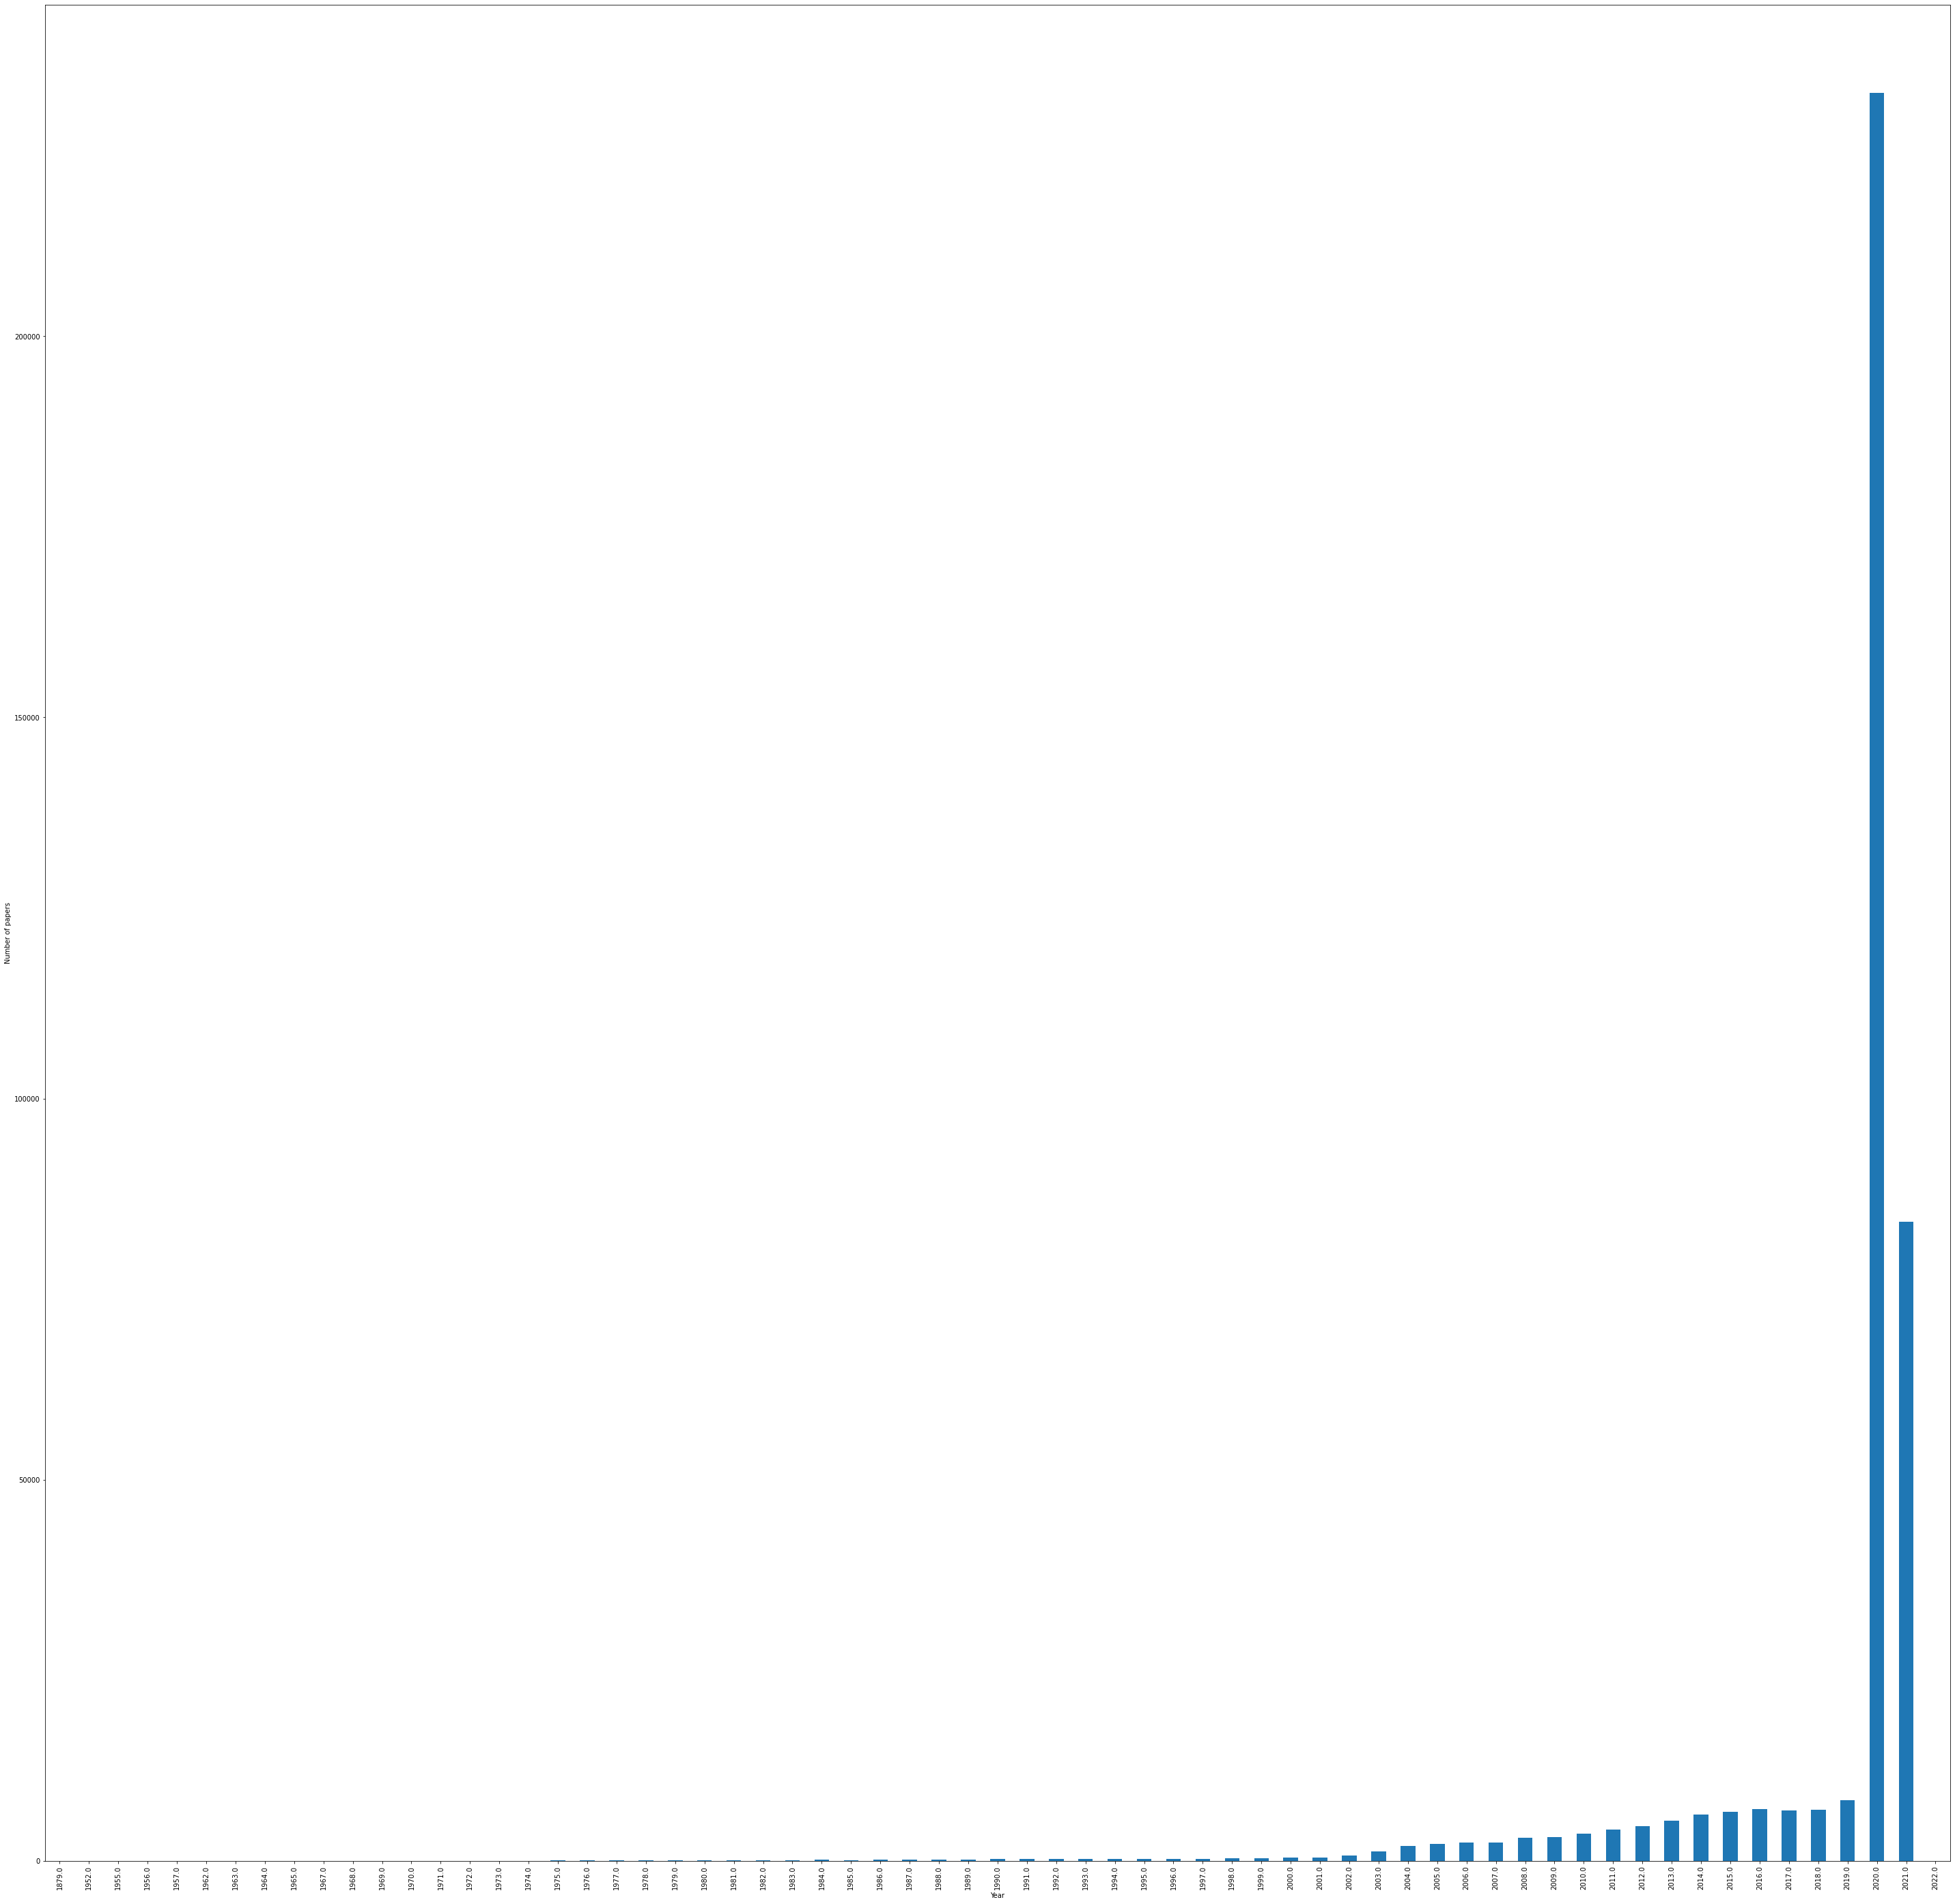

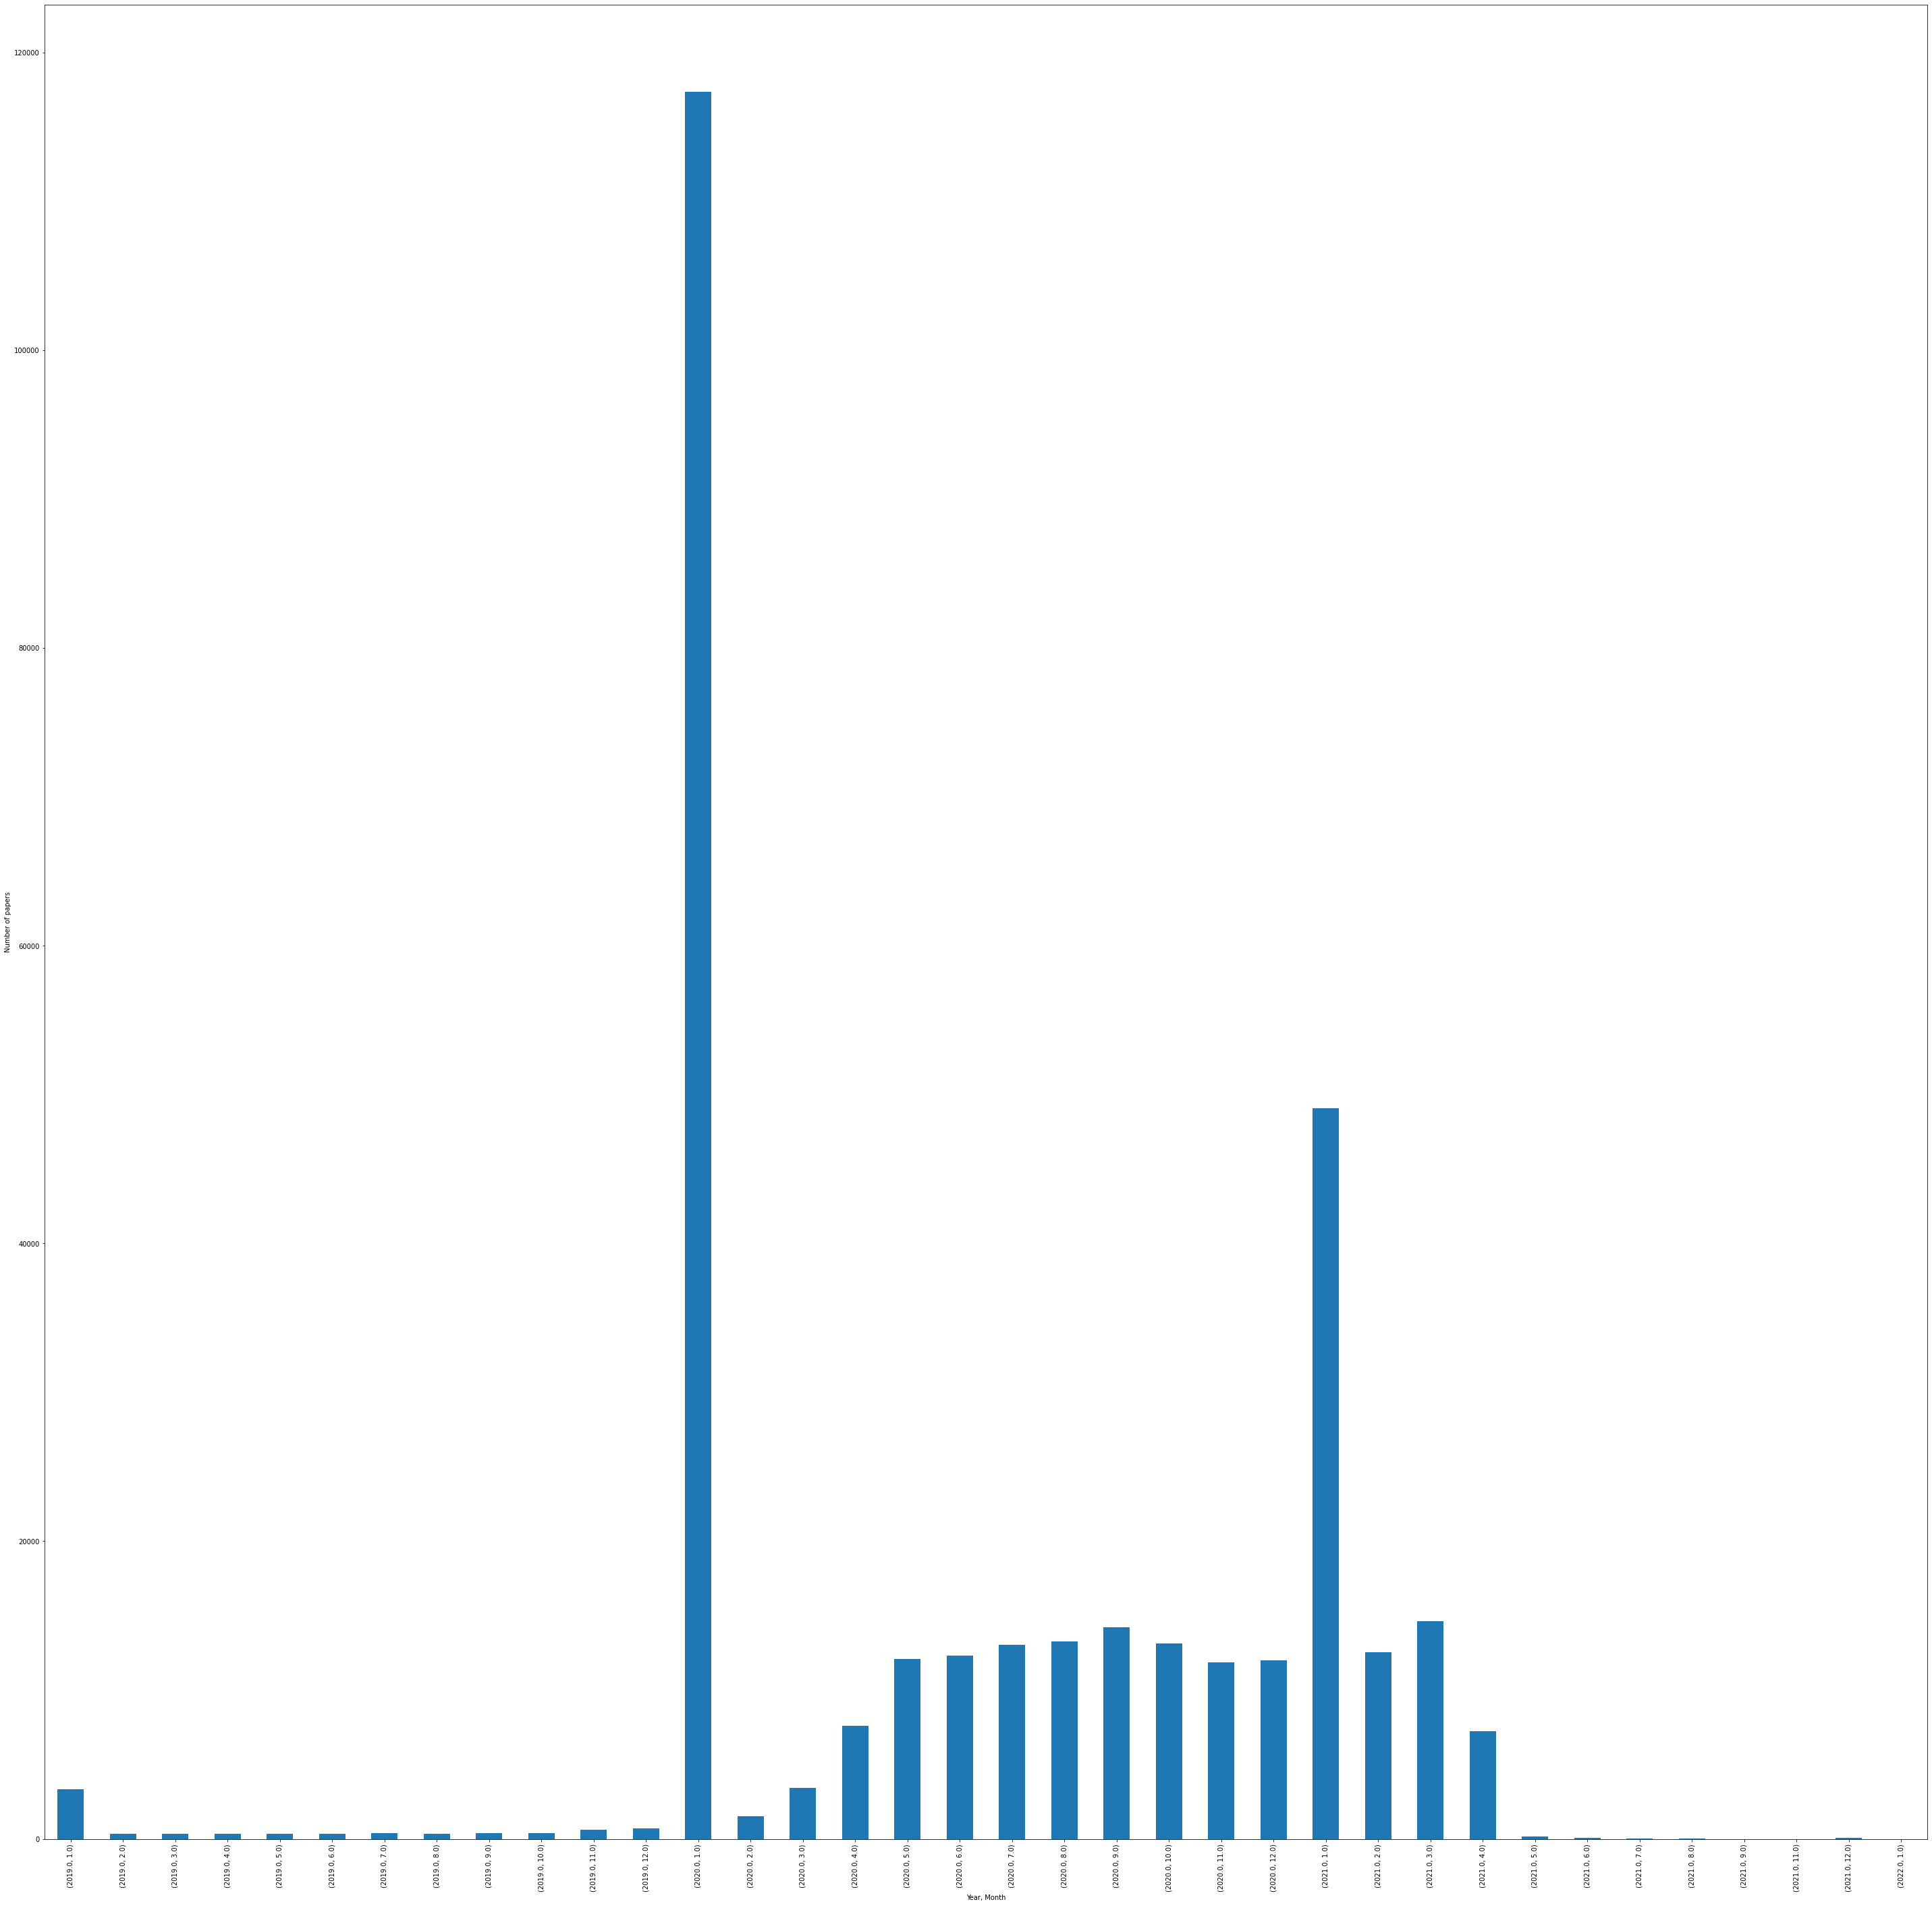

In [6]:
metadata_df['publish_time'] = metadata_df['publish_time'].astype('datetime64')

# Explore the number of published paperes along the years
plt.figure(figsize=(50, 50))
metadata_df['publish_time'].groupby([metadata_df['publish_time'].dt.year]).count().plot(kind='bar')
plt.ylabel('Number of papers')
plt.xlabel('Year')
plt.show()

# Explore the number of published paperes along the last years
plt.figure(figsize=(50, 50))
metadata_df.loc[metadata_df['publish_time'].dt.year >= 2019]['publish_time'].groupby([metadata_df['publish_time'].dt.year, metadata_df['publish_time'].dt.month]).count().plot(kind='bar')
plt.ylabel('Number of papers')
plt.xlabel('Year, Month')
plt.show()

In [9]:
nlp = spacy.load('en_core_web_md')
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

In [10]:
# Explore the abstracts of some random papers to find some special rules for the tokenizer of specific stopwords
for idx, row in shuffle(metadata_df).iloc[:10].iterrows():
    print('==============================================================')
    print(row['title'])
    print(row['publish_time'])
    print()
    print(row['abstract'])
    print()
    doc = nlp(row['abstract'])
    print([tk for tk in doc])
    print()
    print([tk.lemma_ for tk in doc])
    print()
    print([tk.pos_ for tk in doc])
    print()
    print('==============================================================')
    print('\n')

Safety protocols for dental practices in the COVID-19 era
2020-01-01 00:00:00

Aim Aim of this paper was to provide safety and operatory protocols for providing dental care during the COVID19 pandemic.Data sources The protocol is based on summarising the existing literature, published on different aspects of dealing with the pandemic situation. This protocol was established as an international collaboration among three dental universities: Hadassah School of Dental Medicine Israel, the University of Rochester Medical Centre USA, and the University of Pennsylvania USA. The details of the virus-transmission and its impact on dental care are discussed. Additionally, safety and operatory protocols for urgent and emergency dental care are detailed with a special focus on endodontic and surgical dental care.Conclusions A protocol detailing the safety and operatory measures to be taken while giving the dental care in the COVID-era is provided. The primary aim is to prevent any cross-contamina

In [7]:
# Add LanguageDetector and assign it a string name
@Language.factory("language_detector")
def create_language_detector(nlp, name):
    return LanguageDetector(language_detection_function=None)

In [ ]:
mult_nlp = spacy.load('xx_sent_ud_sm')
mult_nlp.add_pipe('language_detector', last=True)

In [8]:
# Explore the vocabulary
results = []
for lex in nlp.vocab:
    r = {}
    r['Term'] = lex.text
    r['Hash'] = lex.orth
    r['Stopword'] = lex.is_stop
    results.append(r)

results_df = pd.DataFrame(results)
results_df

,Term,Hash,Stopword
0,nuthin,17780520906925867008,False
1,ü.,9616619598791593984,False
2,p.m,6364458155313776643,False
3,Kan,8969436956900823045,False
4,Mar,12595687976425261068,False
...,...,...,...
756,She's,7021531544473137138,False
757,ve,10105644630884274164,False
758,E.g.,4115108073383360500,False
759,:-|,280013313535684598,False


In [10]:
# Visualize some stopwords
results_df.loc[results_df['Stopword']]

,Term,Hash,Stopword
14,it,10239237003504588839,True
25,is,3411606890003347522,True
28,Might,9747367433533540424,True
35,where,16318918034475841628,True
46,must,7290638946010101875,True
...,...,...,...
705,They,14947529218328092544,True
714,Had,6865576549405853585,True
733,should,10292920167869855674,True
741,are,5012629990875267006,True


In [9]:
# Add some special cases for the tokenizer
nlp.tokenizer.add_special_case('SARS-CoV-2', [{ORTH: 'SARS'}, {ORTH: '-'}, {ORTH: 'CoV-2'}])
nlp.tokenizer.add_special_case('SARSr-CoV', [{ORTH: 'SARSr'}, {ORTH: '-'}, {ORTH: 'CoV'}])

# Define the valid POS for the abstract tokens
valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])

def abstract_preprocessing(raw_abstract, mult_nlp, nlp, valid_POS):
    '''
    Preprocess the abstract text to extract only the valid lemmas.
    
    Args:
    - raw_abstract (str): Original abstract string.
    - mult_nlp (spacy.lang.xx.MultiLanguage): Multilanguage Spacy tokenizer.
    - nlp (spacy.lang.en.English): English Spacy tokenizer.
    - valid_POS (set): Set of the string representations of the valid POS.
    
    Returns:
    - lemmas (list): List of the valid lemmas of the given abstract.
    '''
    mult_doc = mult_nlp(raw_abstract)
    english_text = ' '.join([sent.text for sent in mult_doc.sents if sent._.language['language'] == 'en'])
    doc = nlp(english_text)
    
    lemmas = []
    for i, token in enumerate(doc):
        if not token.is_stop and (token.is_alpha or token.is_digit) and token.pos_ in valid_POS:
            lemmas.append(token.lemma_)
    
    return lemmas


In [10]:
# Tokenize and lemmatize the data
metadata_df['lemmas'] = metadata_df['abstract'].progress_apply(lambda abstract: abstract_preprocessing(abstract, mult_nlp, nlp, valid_POS))
metadata_df

100%|██████████| 396056/396056 [4:57:21<00:00, 22.20it/s]  
<ipython-input-10-3882f4230122>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['lemmas'] = metadata_df['abstract'].progress_apply(lambda abstract: abstract_preprocessing(abstract, mult_nlp, nlp, valid_POS))


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,lemmas
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,"[retrospective, chart, review, describe, epide..."
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[inflammatory, disease, respiratory, tract, as..."
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[surfactant, protein, d, SP, D, participate, i..."
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[amino, acid, peptide, diverse, biological, ac..."
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[respiratory, syncytial, virus, RSV, pneumonia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544401,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,"Bhavani, R. V.; Gopinath, R.",Food Secur,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0,"[pandemic, see, wake, humanity, reflect, rethi..."
544402,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,"You, Chuanman",Computer Law & Security Review,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0,"[China, experience, phenomenal, expansion, pla..."
544403,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,"Abuhammad, Sawsan; AlAzzam, Manar; Mukattash, ...",Int J Clin Pract,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https://ww.

In [11]:
# Save the preprocessed data
metadata_df.to_csv('./data/metadata_processed.csv', index=False)
nlp.to_disk('./data/en_core_extended')

## Build the corpus

In [3]:
# Load the data
metadata_df = pd.read_csv('./data/metadata_processed.csv', low_memory=False)
metadata_df['lemmas'] = metadata_df['lemmas'].apply(lambda ls_str: [x.strip() for x in eval(ls_str)])
metadata_df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,lemmas
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,"[retrospective, chart, review, describe, epide..."
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[inflammatory, disease, respiratory, tract, as..."
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[surfactant, protein, d, SP, D, participate, i..."
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[amino, acid, peptide, diverse, biological, ac..."
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[respiratory, syncytial, virus, RSV, pneumonia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396051,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,"Bhavani, R. V.; Gopinath, R.",Food Secur,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0,"[pandemic, see, wake, humanity, reflect, rethi..."
396052,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,"You, Chuanman",Computer Law & Security Review,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0,"[China, experience, phenomenal, expansion, pla..."
396053,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,"Abuhammad, Sawsan; AlAzzam, Manar; Mukattash, ...",Int J Clin Pract,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https://ww.

Mean number of tokens: 110.74
Median number of tokens: 111.00
Standard deviation number of tokens: 62.15


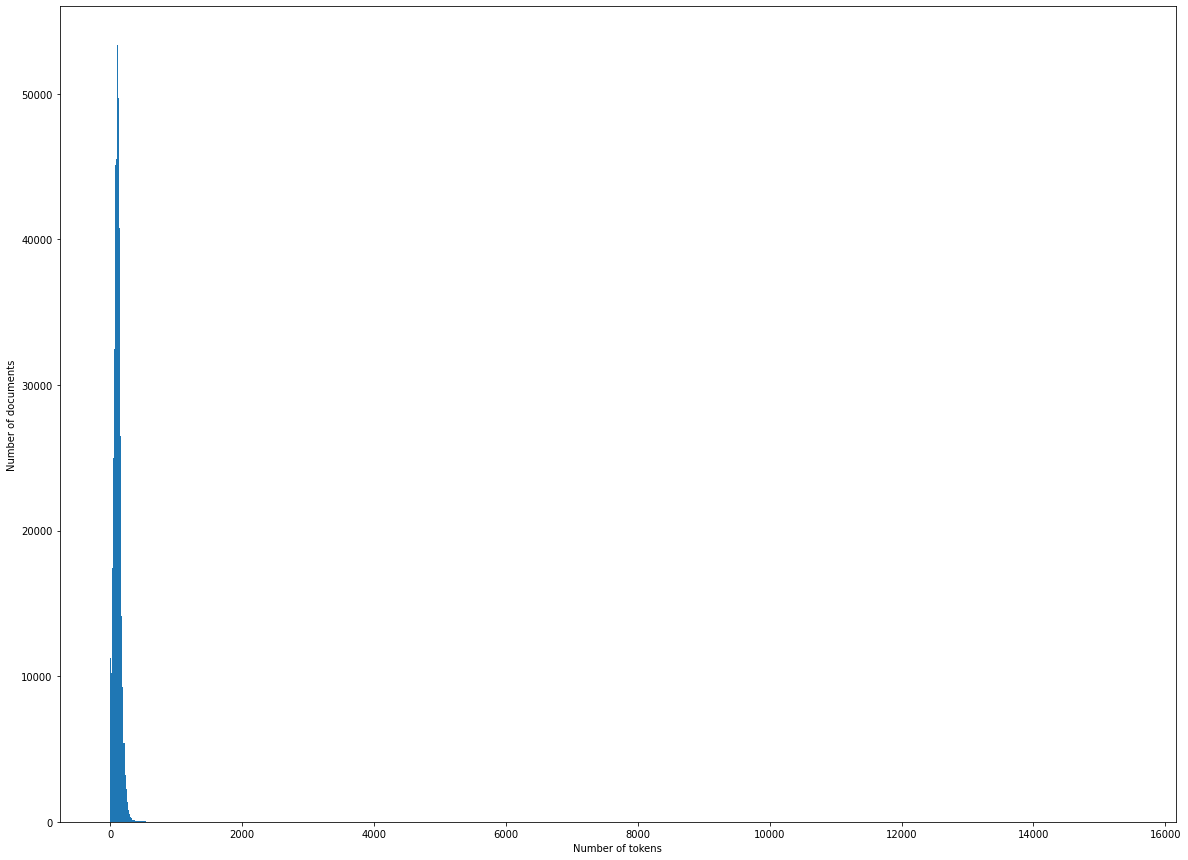

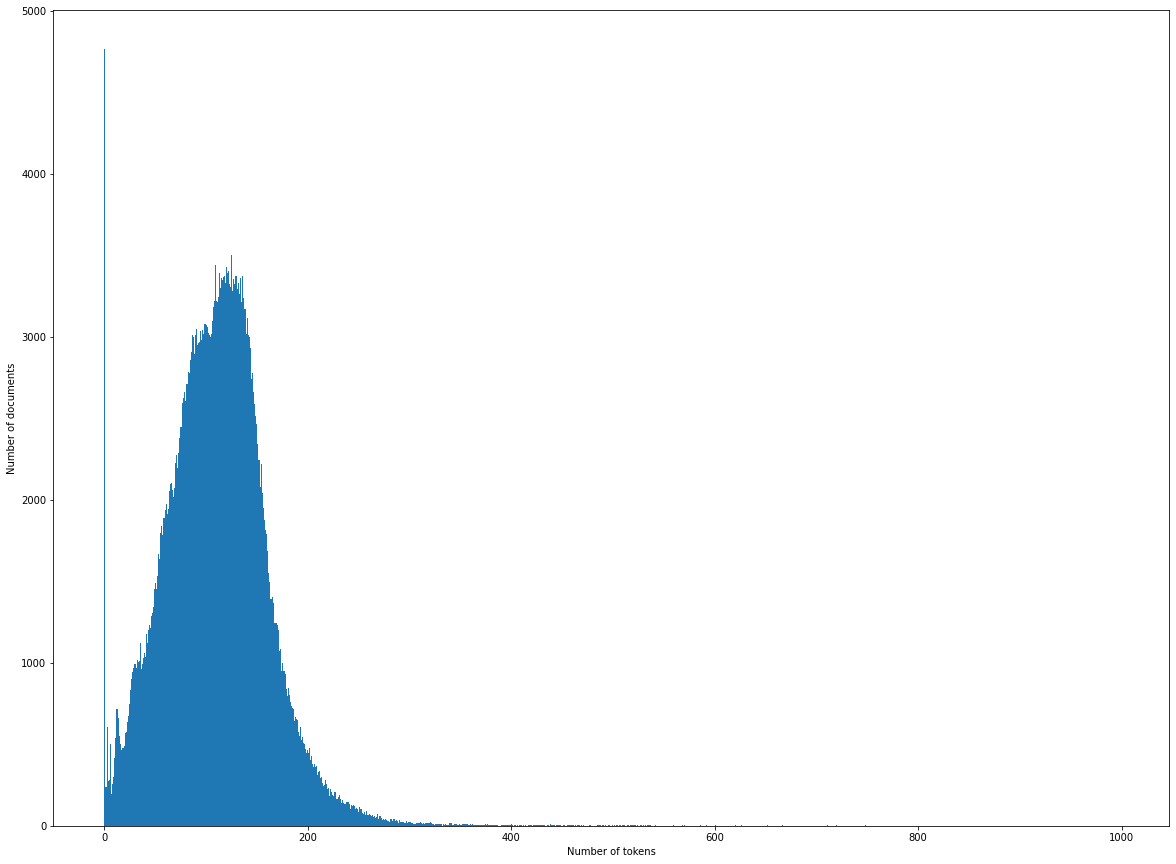

In [4]:
# Explore the number of tokens per document
n_tokens_aux = metadata_df['lemmas'].apply(lambda x: len(x))

print('Mean number of tokens: {:.2f}'.format(n_tokens_aux.mean()))
print('Median number of tokens: {:.2f}'.format(n_tokens_aux.median()))
print('Standard deviation number of tokens: {:.2f}'.format(n_tokens_aux.std()))

plt.figure(figsize=(20,15))
plt.hist(n_tokens_aux, bins=1000)
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.show()

plt.figure(figsize=(20,15))
plt.hist(n_tokens_aux[n_tokens_aux < 1000], bins=1000)
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.show()

In [5]:
# Drop the papers with extreamly short abstracts
metadata_df['nlemmas'] = metadata_df['lemmas'].apply(len)
metadata_df = metadata_df[metadata_df['nlemmas'] > 20]
metadata_df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,lemmas,nlemmas
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,"[retrospective, chart, review, describe, epide...",129
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[inflammatory, disease, respiratory, tract, as...",69
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[surfactant, protein, d, SP, D, participate, i...",133
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[amino, acid, peptide, diverse, biological, ac...",35
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[respiratory, syncytial, virus, RSV, pneumonia...",68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396051,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,...,Food Secur,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0,"[pandemic, see, wake, humanity, reflect, rethi...",71
396052,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,...,Computer Law & Security Review,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0,"[China, experience, phenomenal, expansion, pla...",112
396053,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,...,Int J Clin Pract,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https://ww...,228089464.0,"[study, aim, evaluate, available, content, loc...",102
396054,nrpiyq1g,645c9aec6eed5f1c1436ab4083d35f1107e6467e,Medline; PMC,Choroid Plexus: The Orchestrator of Long-Range...,10.3390/ijms21134760,PMC7369786,32635478,cc-by,Cerebrosp

In [6]:
# Remove the specific stopwords from the lemmas
specific_stw = set(['study', 'result', 'include', 'conclusion', 'base', 'report', 'provide', 'case', 'method', 
                    'present', 'identify', 'show', 'associate', 'compare', 'use', 'aim', 'need', 'find', 'paper',
                    'research', 'propose', 'follow'])


metadata_df['lemmas_clean'] = metadata_df['lemmas'].progress_apply(lambda lemmas: [lemma for lemma in lemmas if lemma not in specific_stw])
metadata_df

100%|██████████| 382386/382386 [00:05<00:00, 71407.43it/s] 
<ipython-input-6-efd0db5d4d45>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['lemmas_clean'] = metadata_df['lemmas'].progress_apply(lambda lemmas: [lemma for lemma in lemmas if lemma not in specific_stw])


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,lemmas,nlemmas,lemmas_clean
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,"[retrospective, chart, review, describe, epide...",129,"[retrospective, chart, review, describe, epide..."
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[inflammatory, disease, respiratory, tract, as...",69,"[inflammatory, disease, respiratory, tract, el..."
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[surfactant, protein, d, SP, D, participate, i...",133,"[surfactant, protein, d, SP, D, participate, i..."
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[amino, acid, peptide, diverse, biological, ac...",35,"[amino, acid, peptide, diverse, biological, ac..."
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[respiratory, syncytial, virus, RSV, pneumonia...",68,"[respiratory, syncytial, virus, RSV, pneumonia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396051,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,...,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0,"[pandemic, see, wake, humanity, reflect, rethi...",71,"[pandemic, see, wake, humanity, reflect, rethi..."
396052,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,...,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0,"[China, experience, phenomenal, expansion, pla...",112,"[China, experience, phenomenal, expansion, pla..."
396053,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,...,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https:/

In [7]:
# Build specific unigrams
unigram_dict = {
    'cerebrospinal fluid' : 'CSF', 
    'cerebral palsy': 'CP', 
    'machine learning': 'ML',
    'deep learning': 'DL',
    'computerized tomography': 'CT',
    'computed tomography': 'CT',
    'porcine epidemic diarrhea virus': 'PEDV',
    'magnetic resonance imaging': 'MRI',
    'multiple sclerosis': 'MS',
    'electrocardiogram': 'ECG',
    'EKG': 'ECG',
}

pattern_unigrams = re.compile(r'\b(' + '|'.join([k for k in unigram_dict]) + r')\b')

metadata_df['lemmas_clean'] = metadata_df['lemmas_clean'].progress_apply(lambda lemmas: pattern_unigrams.sub(lambda x: unigram_dict[x.group()], ' '.join(lemmas)).split(' '))
metadata_df

100%|██████████| 382386/382386 [00:16<00:00, 22857.85it/s]
<ipython-input-7-a820050a0f92>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['lemmas_clean'] = metadata_df['lemmas_clean'].progress_apply(lambda lemmas: pattern_unigrams.sub(lambda x: unigram_dict[x.group()], ' '.join(lemmas)).split(' '))


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,lemmas,nlemmas,lemmas_clean
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,"[retrospective, chart, review, describe, epide...",129,"[retrospective, chart, review, describe, epide..."
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[inflammatory, disease, respiratory, tract, as...",69,"[inflammatory, disease, respiratory, tract, el..."
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[surfactant, protein, d, SP, D, participate, i...",133,"[surfactant, protein, d, SP, D, participate, i..."
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[amino, acid, peptide, diverse, biological, ac...",35,"[amino, acid, peptide, diverse, biological, ac..."
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[respiratory, syncytial, virus, RSV, pneumonia...",68,"[respiratory, syncytial, virus, RSV, pneumonia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396051,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,...,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0,"[pandemic, see, wake, humanity, reflect, rethi...",71,"[pandemic, see, wake, humanity, reflect, rethi..."
396052,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,...,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0,"[China, experience, phenomenal, expansion, pla...",112,"[China, experience, phenomenal, expansion, pla..."
396053,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,...,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https:/

Mean number of tokens: 107.73
Median number of tokens: 106.00
Standard deviation number of tokens: 57.50


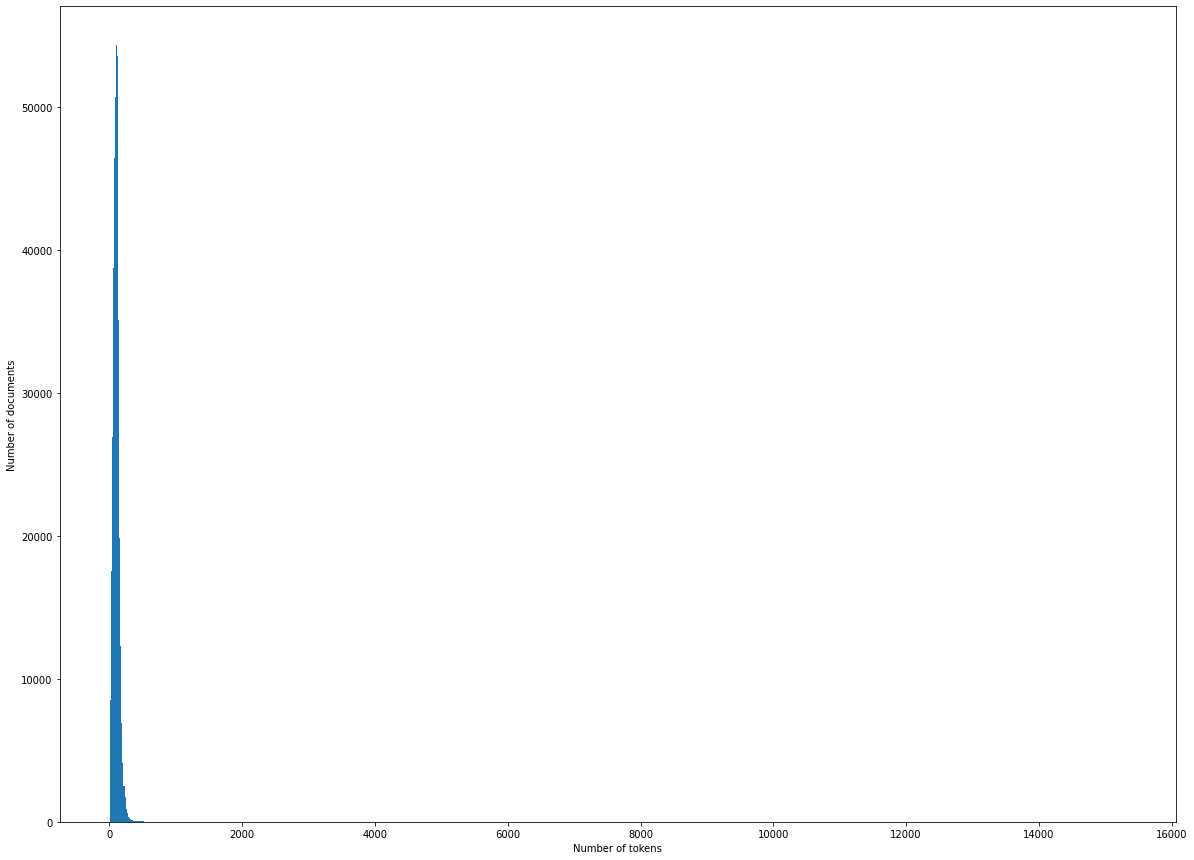

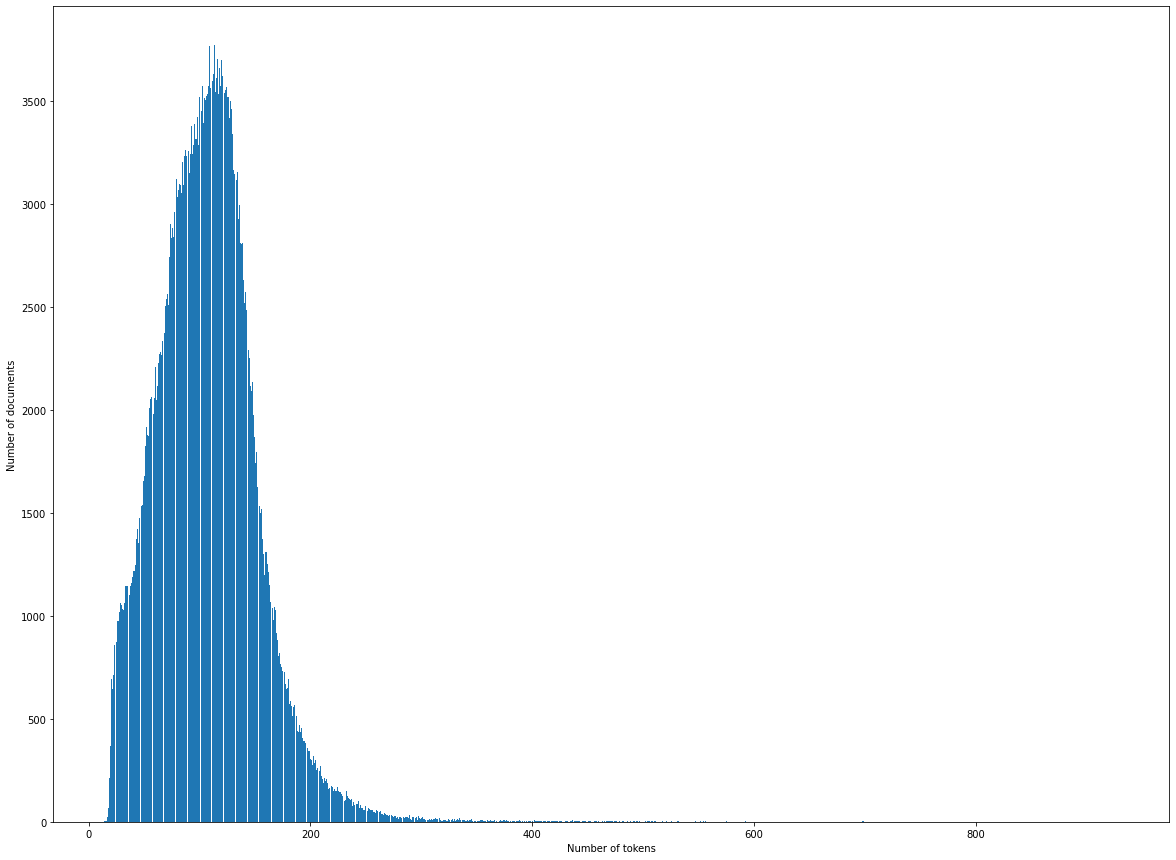

In [8]:
# Explore the number of tokens per document after the cleaning
n_tokens_aux = metadata_df['lemmas_clean'].apply(lambda x: len(x))

print('Mean number of tokens: {:.2f}'.format(n_tokens_aux.mean()))
print('Median number of tokens: {:.2f}'.format(n_tokens_aux.median()))
print('Standard deviation number of tokens: {:.2f}'.format(n_tokens_aux.std()))

plt.figure(figsize=(20,15))
plt.hist(n_tokens_aux, bins=1000)
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.show()

plt.figure(figsize=(20,15))
plt.hist(n_tokens_aux[n_tokens_aux < 1000], bins=1000)
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.show()

In [9]:
# Build the corpus and compute N-gram detection and replacement
corpus = metadata_df['lemmas_clean'].to_list()
phrase_model = Phrases(corpus, min_count=2, threshold=20)

print('\n============= First document in corpus =============')
print(corpus[0])
corpus = [el for el in phrase_model[corpus]]
print('\n============= First document after N-gram replacement =============')
print(corpus[0])


============= First document in corpus =============
['retrospective', 'chart', 'review', 'describe', 'epidemiology', 'clinical', 'feature', 'patient', 'culture', 'prove', 'Mycoplasma', 'pneumoniae', 'infection', 'King', 'Abdulaziz', 'University', 'Hospital', 'Jeddah', 'Saudi', 'Arabia', 'patient', 'positive', 'pneumoniae', 'culture', 'respiratory', 'specimen', 'January', 'December', 'Microbiology', 'record', 'chart', 'patient', 'review', 'patient', 'require', 'admission', 'infection', 'community', 'acquire', 'infection', 'affect', 'age', 'group', 'common', 'infant', 'pre', 'school', 'child', 'occur', 'year', 'round', 'common', 'fall', 'spring', 'quarter', 'patient', 'comorbiditie', 'isolate', 'pneumonia', 'upper', 'respiratory', 'tract', 'infection', 'bronchiolitis', 'Cough', 'fever', 'malaise', 'common', 'symptom', 'crepitation', 'wheeze', 'common', 'sign', 'patient', 'pneumonia', 'crepitation', 'bronchial', 'breathing', 'immunocompromised', 'patient', 'likely', 'non', 'immunocompro

In [10]:
# Create dictionary of tokens
D = Dictionary(corpus)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 455997 terms
First terms in the dictionary:
0 : Arabia
1 : Cough_fever
2 : January_December
3 : Jeddah_Saudi
4 : King_Abdulaziz
5 : M
6 : Microbiology
7 : Mycoplasma_pneumoniae
8 : University_Hospital
9 : admission


In [11]:
df_aux = pd.DataFrame([{'token': D[idx], 'ndocs': val} for idx, val in D.dfs.items()])

just_one_doc = df_aux.loc[df_aux['ndocs'] == 1]
print('Number of tokens appearing in just one document: {}'.format(len(just_one_doc)))
df_aux = df_aux.loc[df_aux['ndocs'] != 1]

df_aux = df_aux.sort_values('ndocs', ascending=False)

print(df_aux.head(20))
print(df_aux.tail(20))

Number of tokens appearing in just one document: 129940
             token   ndocs
6          patient  149014
74         disease  140088
1373      pandemic  124662
72            high  117177
10       infection  106019
67           datum   93253
79        increase   92191
4         clinical   86747
861           SARS   83948
23307  coronavirus   80138
1277          risk   76824
180          virus   75923
472       analysis   75446
571           time   73767
641      treatment   71679
353         health   67779
223          cause   67694
323          level   65373
322            low   62778
721        develop   62669
                            token  ndocs
276800             mongolian_adna      2
276798                  HybProbes      2
276796                    SGF_min      2
276792       sphingosine_analogue      2
276791              movement_gaze      2
276790            rehabilitationA      2
276789                  Dynamixel      2
276787               amputee_user      2
276786  

In [12]:
df_aux.describe()

,ndocs
count,326057.000000
mean,80.100789
std,1250.339205
min,2.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,149014.000000


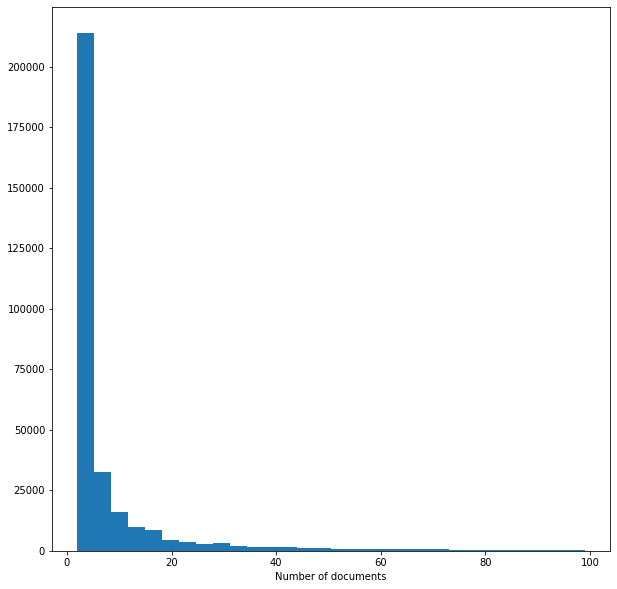

In [13]:
plt.figure(figsize=(10, 10))
plt.hist(df_aux['ndocs'][df_aux['ndocs'] < 100], bins=30)
plt.xlabel('Number of documents')
plt.show()

In [14]:
no_below = 8 # Minimum number of documents to keep a term in the dictionary
no_above = .80 # Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

The dictionary contains 87629 terms


In [15]:
df_aux = pd.DataFrame([{'token': D[idx], 'ndocs': val} for idx, val in D.dfs.items()])
df_aux = df_aux.sort_values('ndocs', ascending=False)

print(df_aux.head(20))
print(df_aux.tail(20))

             token   ndocs
6          patient  149014
73         disease  140088
1298      pandemic  124662
71            high  117177
10       infection  106019
67           datum   93253
78        increase   92191
4         clinical   86747
823           SARS   83948
18147  coronavirus   80138
1204          risk   76824
175          virus   75923
461       analysis   75446
550           time   73767
616      treatment   71679
347         health   67779
218          cause   67694
317          level   65373
316            low   62778
694        develop   62669
                          token  ndocs
78134                         φ      8
58512           exclude_outlier      8
78103           potassium_spare      8
58546                       npd      8
58544      hippocampus_amygdala      8
78110                       BPN      8
78111      intravenous_sedative      8
42186        Tasmania_Australia      8
78113      ThermoFisher_TaqPath      8
78114          BinaxNOW_antigen      8
5854

In [16]:
corpus_bow = [D.doc2bow(doc) for doc in corpus]

n_project = 1000
print('============= Project abstract (lemmas) =============')
print(' '.join(corpus[n_project]))

print('\n============= Sparse vector representation =============')
print(corpus_bow[n_project])

print('\n============= Word counts for the project =============')
print(list(map(lambda x: (D[x[0]], x[1]), corpus_bow[n_project])))

============= Project abstract (lemmas) =============
human_bocavirus HBoV_discover child respiratory_distress diarrhea knowledge previous existence bocavirus Saudi_Arabia swab sample child respiratory_tract infection examine presence real_time polymerase_chain reaction sensitive detect direct gene sequence determine genotype detect virus isolate HBoV detect examine patient partial gene sequence patient circulate strain relate genotype HBoV infected patient evidence mixed coinfection viral pathogen current demonstrate conserve circulate Saudi_Arabia infected high rate co infection virus

============= Sparse vector representation =============
[(16, 2), (32, 1), (35, 2), (36, 1), (44, 3), (52, 1), (87, 1), (119, 1), (191, 2), (224, 1), (232, 2), (242, 1), (243, 1), (244, 1), (255, 1), (265, 1), (268, 1), (297, 2), (467, 1), (551, 1), (578, 1), (583, 2), (617, 3), (717, 1), (1020, 1), (1022, 1), (1041, 2), (1134, 1), (1141, 1), (1268, 1), (1436, 1), (1681, 1), (1978, 2), (1986, 1), (199

## ❤️ CHECKPOINT ❤️

In [17]:
# Save the metadata dataframe
metadata_df.to_csv('./data/metadata_processed.csv', index=False)
# Save the dictionary
D.save('./data/gensim_dictionary')
# Save corpus
pickle.dump(corpus, open('./data/corpus.pkl', 'wb'))
# Save corpus
pickle.dump(corpus_bow, open('./data/corpus_bow.pkl', 'wb'))

In [3]:
# Save the metadata dataframe
metadata_df = pd.read_csv('./data/metadata_processed.csv')
# Load the dictionary
D = Dictionary.load('./data/gensim_dictionary')
# Load corpus
corpus = pickle.load(open('./data/corpus.pkl', 'rb'))
# Load corpus
corpus_bow = pickle.load(open('./data/corpus_bow.pkl', 'rb'))

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Speech & Natural Language Processing/Labs/FINAL PROJECT/CORD-19-NLP/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Find appropiate number of topics

 17%|█▋        | 1/6 [04:15<21:19, 256.00s/it]

Estimated coherence for a model with 5 topics: 0.4766


 33%|███▎      | 2/6 [10:02<20:37, 309.39s/it]

Estimated coherence for a model with 10 topics: 0.5096


 50%|█████     | 3/6 [17:09<18:08, 362.99s/it]

Estimated coherence for a model with 15 topics: 0.5343


 67%|██████▋   | 4/6 [25:16<13:43, 411.76s/it]

Estimated coherence for a model with 20 topics: 0.5208


 83%|████████▎ | 5/6 [34:58<07:53, 473.40s/it]

Estimated coherence for a model with 25 topics: 0.5207


100%|██████████| 6/6 [52:03<00:00, 520.54s/it]

Estimated coherence for a model with 50 topics: 0.4723
Best number of topics: 15


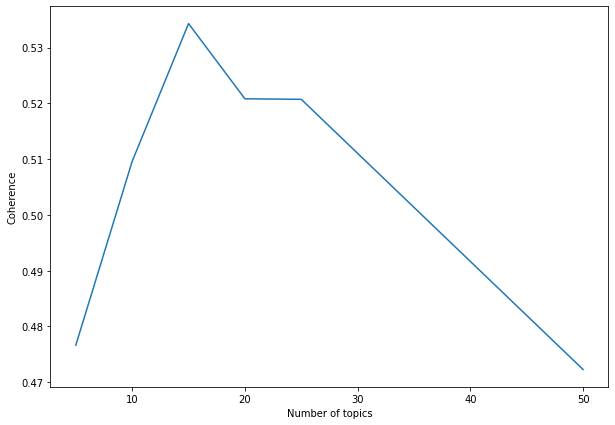

In [14]:
# Search for the ideal number of topics
n_topics = [5, 10, 15, 20, 25, 50]

coh_ls = []
for nt in tqdm(n_topics):

    ldag_n = LdaModel(corpus=corpus_bow, id2word=D, num_topics=nt)
    coherencemodel = CoherenceModel(ldag_n, texts=corpus, dictionary=D, coherence='c_v')

    coh = coherencemodel.get_coherence()
    print('Estimated coherence for a model with {} topics: {:.4f}'.format(nt, coh))
    coh_ls.append(coh)

best_n_topics = n_topics[np.argmax(coh_ls)]
print('Best number of topics:', best_n_topics)

plt.figure(figsize=(10,7))
plt.plot(n_topics, coh_ls, marker='x')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.show()

 11%|█         | 1/9 [07:08<57:10, 428.76s/it]

Estimated coherence for a model with 11 topics: 0.5105


 22%|██▏       | 2/9 [14:19<50:09, 429.86s/it]

Estimated coherence for a model with 12 topics: 0.5243


 33%|███▎      | 3/9 [23:02<47:14, 472.46s/it]

Estimated coherence for a model with 13 topics: 0.5484


 44%|████▍     | 4/9 [31:32<40:36, 487.39s/it]

Estimated coherence for a model with 14 topics: 0.5365


 56%|█████▌    | 5/9 [39:34<32:20, 485.21s/it]

Estimated coherence for a model with 15 topics: 0.5218


 67%|██████▋   | 6/9 [48:17<24:54, 498.06s/it]

Estimated coherence for a model with 16 topics: 0.5208


 78%|███████▊  | 7/9 [57:15<17:02, 511.23s/it]

Estimated coherence for a model with 17 topics: 0.5414


 89%|████████▉ | 8/9 [1:05:39<08:28, 508.97s/it]

Estimated coherence for a model with 18 topics: 0.5239


100%|██████████| 9/9 [1:14:34<00:00, 497.13s/it]

Estimated coherence for a model with 19 topics: 0.5255
Best number of topics: 13


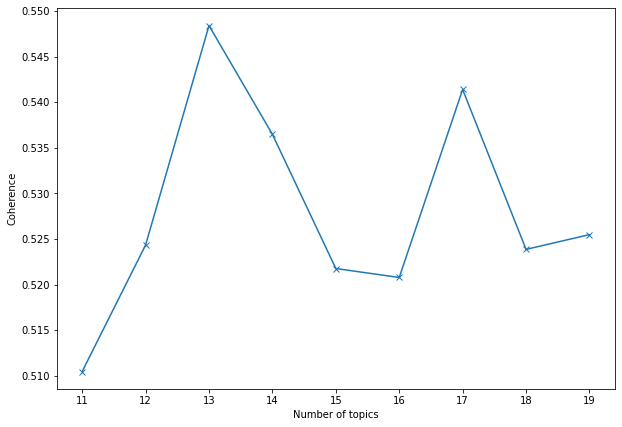

In [15]:
# Search for the ideal number of topics in a more precise approx
n_topics = list(range(best_n_topics - 4, best_n_topics + 5))

coh_ls = []
for nt in tqdm(n_topics):

    ldag_n = LdaModel(corpus=corpus_bow, id2word=D, num_topics=nt)
    coherencemodel = CoherenceModel(ldag_n, texts=corpus, dictionary=D, coherence='c_v')

    coh = coherencemodel.get_coherence()
    print('Estimated coherence for a model with {} topics: {:.4f}'.format(nt, coh))
    coh_ls.append(coh)

best_n_topics = n_topics[np.argmax(coh_ls)]
print('Best number of topics:', best_n_topics)

plt.figure(figsize=(10,7))
plt.plot(n_topics, coh_ls, marker='x')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.show()

## ❤️ CHECKPOINT ❤️

In [8]:
D = Dictionary.load('./data/gensim_dictionary')
corpus = pickle.load(open('./data/corpus.pkl', 'rb'))
corpus_bow = pickle.load(open('./data/corpus_bow.pkl', 'rb'))

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Speech & Natural Language Processing/Labs/FINAL PROJECT/CORD-19-NLP/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Topic modelling - Final LDA model

In [4]:
best_n_topics = 13
# Train LDA model
ldag = LdaModel(corpus=corpus_bow, id2word=D, num_topics=best_n_topics)
ldag.save('./data/lda.model')

# Display all topics including 10 most relevant tokens per topic
ldag.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Speech & Natural Language Processing/Labs/FINAL PROJECT/CORD-19-NLP/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.141*"child" + 0.036*"woman" + 0.024*"disorder" + 0.022*"pregnancy" + 0.021*"depression" + 0.020*"pregnant_woman" + 0.019*"parent" + 0.017*"infant" + 0.015*"CP" + 0.014*"adult"'),
 (1,
  '0.011*"system" + 0.009*"method" + 0.007*"use" + 0.007*"base" + 0.006*"process" + 0.006*"application" + 0.006*"technology" + 0.005*"high" + 0.005*"technique" + 0.005*"time"'),
 (2,
  '0.023*"pandemic" + 0.016*"health" + 0.012*"country" + 0.010*"social" + 0.009*"impact" + 0.009*"research" + 0.008*"policy" + 0.007*"public_health" + 0.007*"global" + 0.006*"people"'),
 (3,
  '0.036*"model" + 0.022*"datum" + 0.015*"base" + 0.014*"result" + 0.014*"study" + 0.013*"number" + 0.012*"analysis" + 0.012*"case" + 0.012*"method" + 0.010*"estimate"'),
 (4,
  '0.024*"care" + 0.019*"pandemic" + 0.013*"health" + 0.011*"patient" + 0.010*"medical" + 0.009*"practice" + 0.008*"include" + 0.008*"service" + 0.007*"provide" + 0.007*"study"'),
 (5,
  '0.038*"vaccine" + 0.029*"treatment" + 0.029*"drug" + 0.018*"trial" +

In [6]:
ldag = LdaModel.load('./data/lda.model')
best_n_topics = len(ldag.show_topics(num_topics=-1))

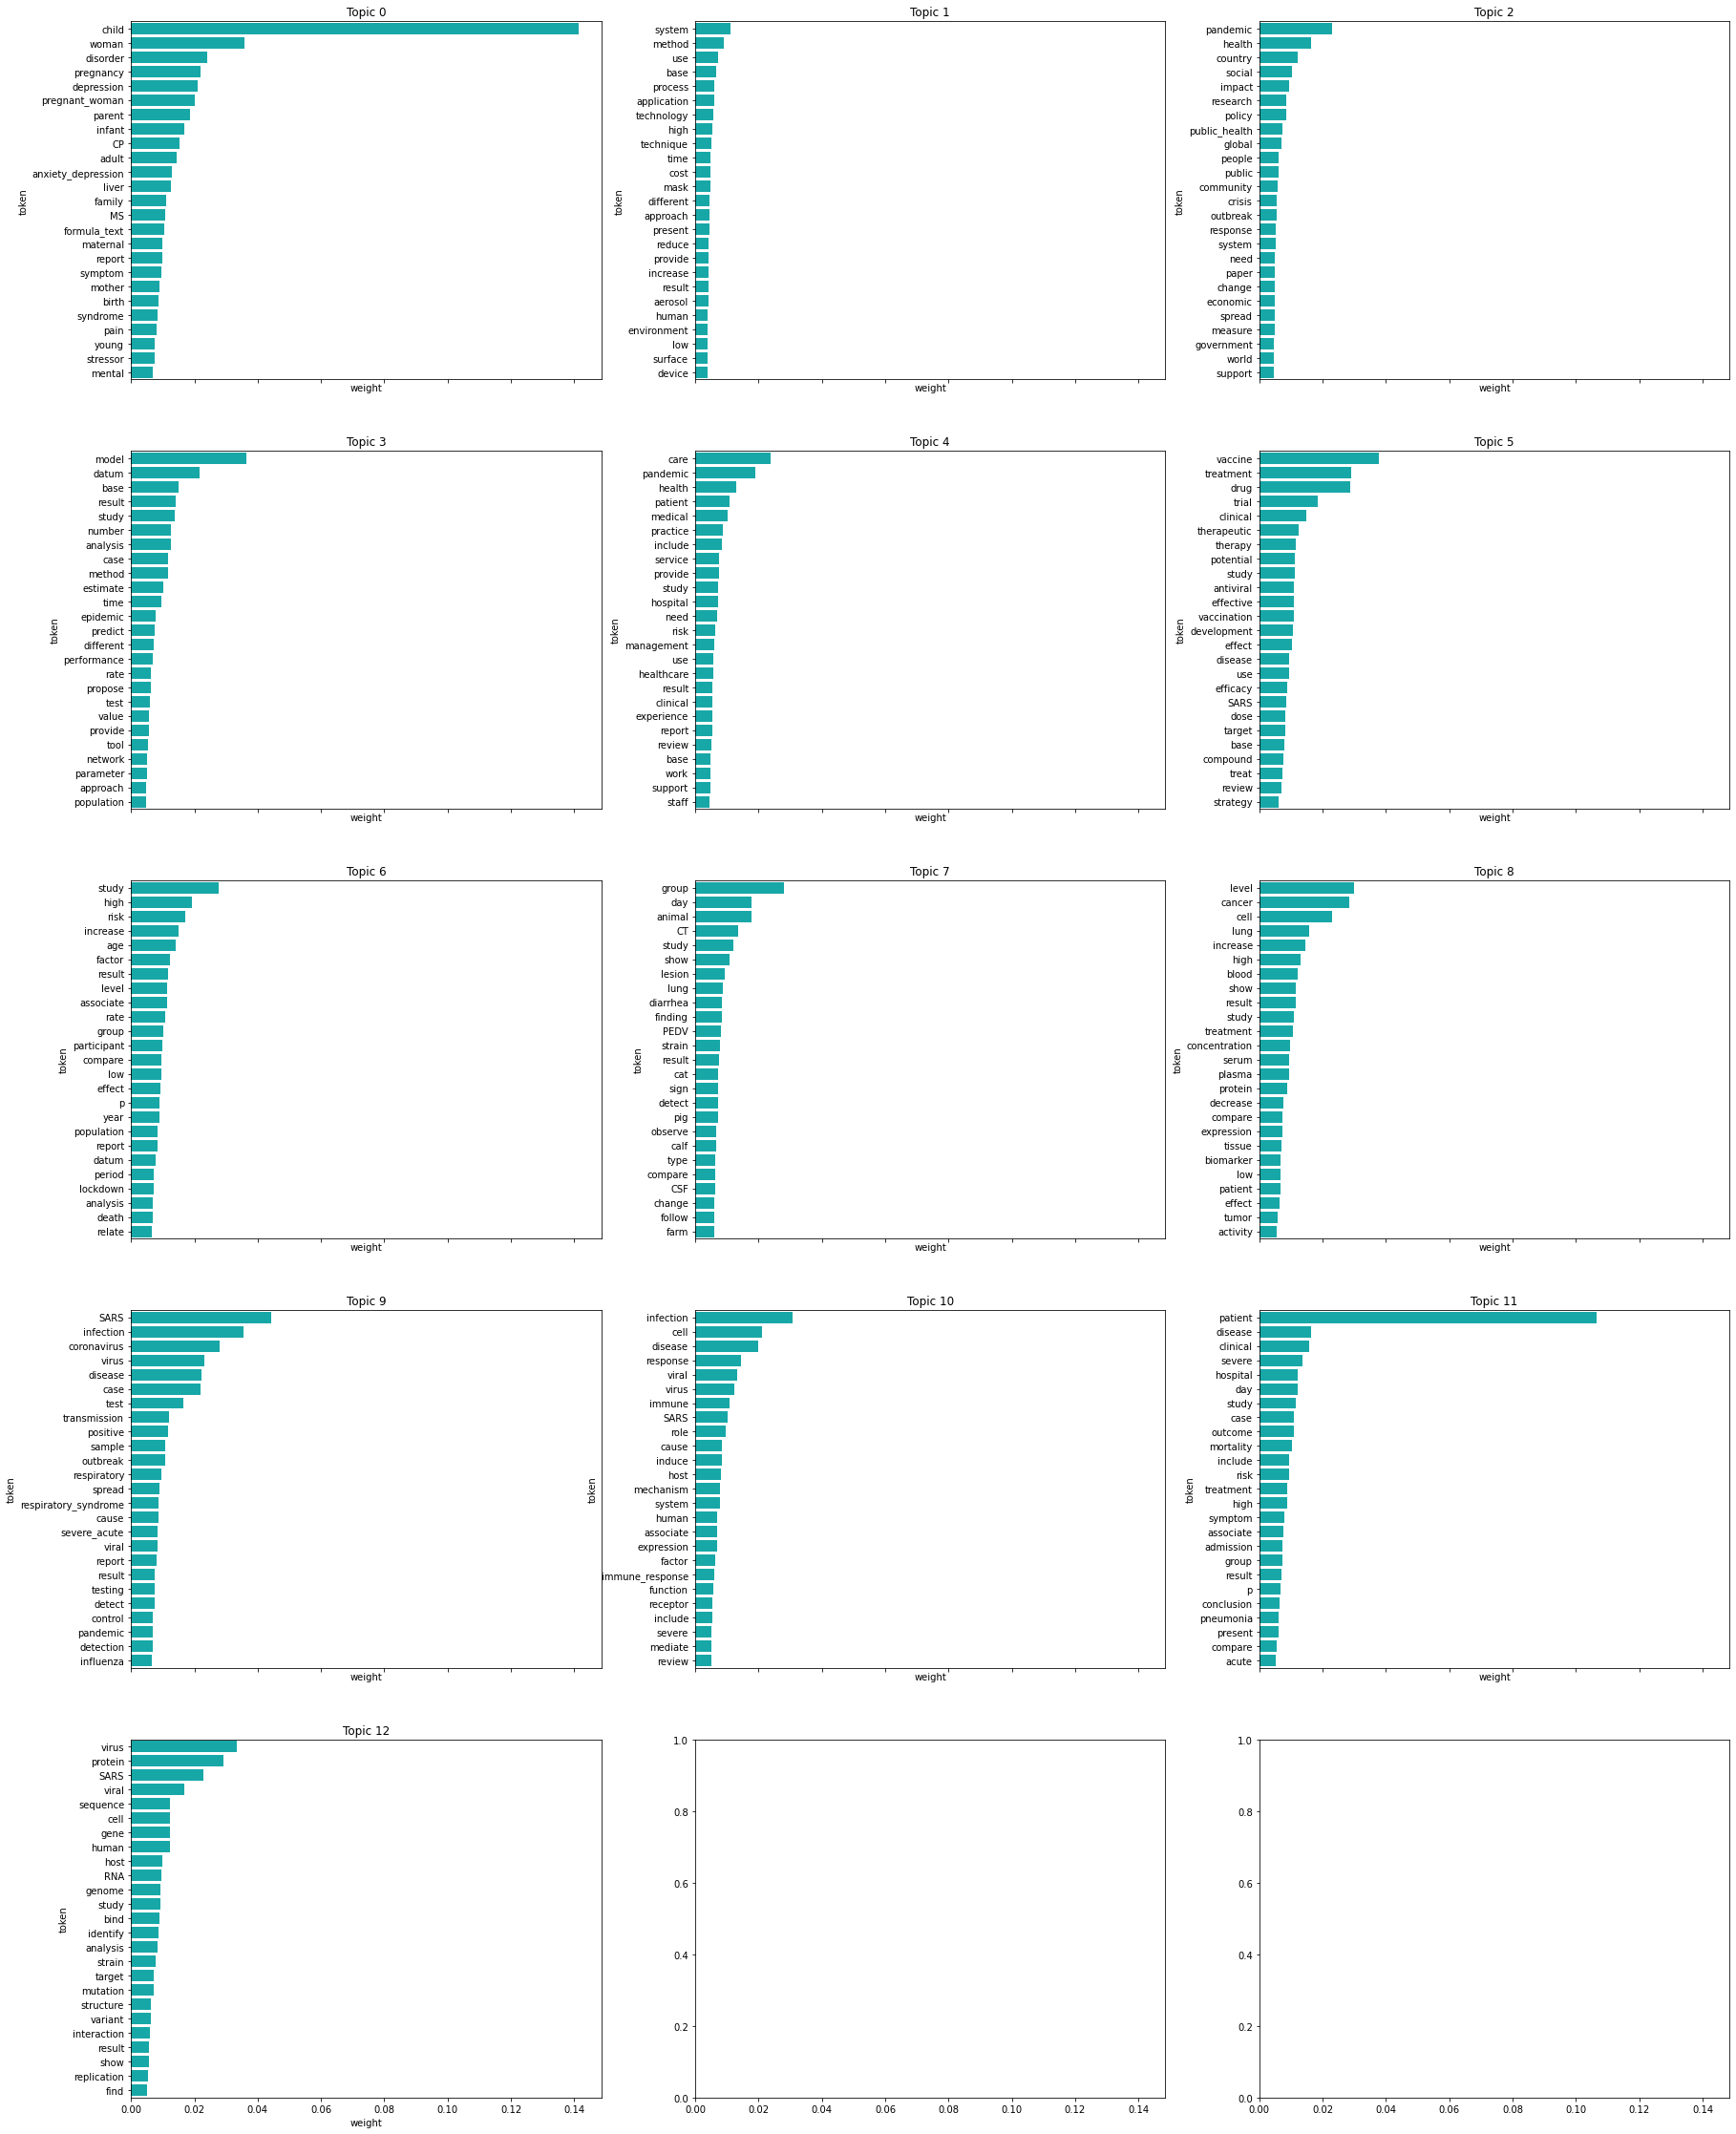

In [17]:
topn = 25

fig, axes = plt.subplots(5, 3, figsize=(30, 40), sharex=True)
x = 0

for i in range(best_n_topics):
    # Build a dataframe with columns 'token' and 'weight' for topic i
    df_weights = pd.DataFrame([{'token': t, 'weight': w} for t, w in ldag.show_topic(i, topn=topn)])
    
    ax = axes[x][i - (3 * x)]
    x += 1 if (i + 1) % 3 == 0 else 0
    sns.barplot(x='weight', y='token', data=df_weights, color='c', orient='h', ax=ax)
    ax.set_title('Topic ' + str(i))
    
plt.show()

In [8]:
# Compute the coherence per topic
coherencemodel = CoherenceModel(ldag, texts=corpus, dictionary=D, coherence='c_v')
print('The coherence of the trained model is', coherencemodel.get_coherence())

df_coherence = pd.DataFrame([{'topic_id': i, 'coherence': c} for i, c in enumerate(coherencemodel.get_coherence_per_topic())])
df_coherence.sort_values('coherence', ascending=False)

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Speech & Natural Language Processing/Labs/FINAL PROJECT/CORD-19-NLP/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The coherence of the trained model is 0.5029333004480587


,topic_id,coherence
12,12,0.708137
2,2,0.631611
10,10,0.630172
9,9,0.566546
5,5,0.546551
11,11,0.501549
8,8,0.481839
4,4,0.463583
0,0,0.449551
7,7,0.432775


In [9]:
vis_data = gensimvis.prepare(ldag, corpus_bow, D)
pyLDAvis.display(vis_data)

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Speech & Natural Language Processing/Labs/FINAL PROJECT/CORD-19-NLP/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
def most_relevant_documents(ldag, topicid, corpus_bow, ndocs=10):
    '''
    This function returns the most relevant documents in corpus_bow
    
    Args:
    - ldag: The trained topic model object provided by gensim
    - topicid: The topic for which we want to find the most relevant documents
    - corpus_bow: The BoW representation of documents in Gensim format
    - ndocs: Number of most relevant documents to return
    
    Returns: 
    - A list with the identifiers of the most relevant documents
    '''

    print('Computing most relevant documents for Topic', topicid)
    print('Topic composition is:')
    print(ldag.show_topic(topicid))
    
    corpus_ldag = ldag[corpus_bow]

    scores = []
    for c in corpus_ldag:
        try:
            scores.append(c[topicid][1])
        except:
            scores.append(0)

    return np.array(scores).argsort()[-ndocs:][::-1]    
    
for t in range(best_n_topics):
    print('Topic', t)
    print('')
    project_id = most_relevant_documents(ldag, t, corpus_bow, ndocs=3)

    # Print abstracts of selected projects
    for idproject in project_id:
        print('\n', ' '.join(corpus[idproject]))
        
    print('==================================================================')

/home/hl0d0w1g/data/Educación/Master Ing de la Informacion para la Salud/Speech & Natural Language Processing/Labs/FINAL PROJECT/CORD-19-NLP/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0

Computing most relevant documents for Topic 0
Topic composition is:
[('study', 0.034164015), ('risk', 0.018647186), ('high', 0.016436234), ('age', 0.015894666), ('result', 0.012749537), ('associate', 0.011705475), ('factor', 0.011019012), ('report', 0.010509707), ('participant', 0.010167673), ('datum', 0.009773185)]

 background pandemic place significant burden mental_health wellbeing frontline health social care worker need support frontline staff recognise date little research good support mental_health need frontline_worker experience view helpful set redress research gap explore UK frontline health social care worker experience view psychosocial support pandemic frontline health social care worker recruit social_medium snowball_sampling healthcare colleague worker volunteer study interview follow semi_structured interview guide transcript interview analyse research team follow principle Reflexive Thematic_Analysis conduct interview frontline_worker variety professional gr

In [7]:
len(corpus_bow) == len(metadata_df)

True

In [8]:
bow_topics = []
for bow in tqdm(corpus_bow):
    topics = ldag.get_document_topics(bow, minimum_probability=0.000000000001)
    assert(len(topics) == best_n_topics)
    
    topics_dict = {}
    for t in range(best_n_topics):
        topics_dict['topic_' + str(topics[t][0])] = topics[t][1]
        
    bow_topics.append(topics_dict)

topics_docs_df = pd.DataFrame(bow_topics)
assert(len(metadata_df) == len(topics_docs_df))

metadata_df = pd.concat([metadata_df, topics_docs_df], axis=1)
metadata_df

100%|██████████| 382386/382386 [02:45<00:00, 2311.48it/s]


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,0.000750,0.033071,0.000750,0.066763,0.000750,0.000750,0.120766,0.000750,0.749918,0.000750
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,0.001309,0.001309,0.001309,0.001309,0.001309,0.251973,0.045672,0.398796,0.110390,0.001309
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,0.000779,0.000779,0.042475,0.000779,0.087422,0.130546,0.000779,0.432916,0.000779,0.216172
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,0.002409,0.002409,0.002409,0.055604,0.002409,0.002409,0.002409,0.484796,0.002409,0.058977
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,0.001378,0.001378,0.138154,0.001378,0.001378,0.065390,0.093327,0.519056,0.031862,0.142566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382381,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643.0,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,...,0.001679,0.098725,0.001678,0.001678,0.090426,0.042462,0.001678,0.152735,0.001678,0.133553
382382,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,...,0.157696,0.072973,0.056434,0.019413,0.056575,0.031094,0.001171,0.084113,0.025855,0.255237
382383,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522.0,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,...,0.086732,0.042808,0.000944,0.000944,0.000944,0.186472,0.127844,0.090816,0.056199,0.100183
382384,nrpiyq1g,645c9aec6eed5f1c1436ab4083d35f1107e6467e,Medline; PMC,Choroid Plexus: The Orchestrator of Long-Range...,10.3390/ijms21134760,PMC7369786,32635478.0,cc-by,Cerebrospinal fluid (CSF) is the liquid that f...,2020-07-04,...,0.000921,0.076564,0.195940,0.000921,0.046526,0.056013,0.000921,0.121836,0.109548,0.255420


In [ ]:
!pip install crossrefapi==1.0.3

In [ ]:
from crossref.restful import Works

works = Works()
info = works.doi('10.1038/s41591-020-1132-9')

info

In [ ]:
for idx, row in data.iterrows():
    info = works.doi(row['doi'])
    print([a['affiliation'] for a in info['author']])